In [1]:
%cd ../

D:\workspace\github\torchsignal


In [11]:
from torchsignal.datasets import OPENBMI
from torchsignal.datasets.multiplesubjects import MultipleSubjects
from torchsignal.trainer.multitask import Multitask_Trainer
from torchsignal.model import MultitaskSSVEP

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [9]:
config = {
  "exp_name": "multitask-run1",
  "seed": 12,
  "segment_config": {
    "window_len": 1,
    "shift_len": 1000,
    "sample_rate": 1000,
    "add_segment_axis": True
  },
  "bandpass_config": {
      "sample_rate": 1000,
      "lowcut": 1,
      "highcut": 40,
      "order": 6
  },
  "train_subject_ids": {
    "low": 1,
    "high": 54
  },
  "test_subject_ids": {
    "low": 1,
    "high": 54
  },
  "root": "../data/openbmi",
  "selected_channels": ['P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10'],
  "sessions": [1,2],
  "tsdata": False,
  "num_classes": 4,
  "num_channel": 10,
  "batchsize": 256,
  "learning_rate": 0.001,
  "epochs": 100,
  "patience": 5,
  "early_stopping": 10,
  "model": {
    "n1": 4,
    "kernel_window_ssvep": 59,
    "kernel_window": 19,
    "conv_3_dilation": 4,
    "conv_4_dilation": 4
  },
  "gpu": 0,
  "multitask": True,
  "runkfold": 4,
  "check_model": True
}

device = torch.device("cuda:"+str(config['gpu']) if torch.cuda.is_available() else "cpu")
print('device', device)

device cuda:0


# Load Data - OPENBMI

In [4]:
subject_ids = list(np.arange(config['train_subject_ids']['low'], config['train_subject_ids']['high']+1, dtype=int))

openbmi_data = MultipleSubjects(
    dataset=OPENBMI, 
    root=config['root'], 
    subject_ids=subject_ids, 
    sessions=config['sessions'],
    selected_channels=config['selected_channels'],
    segment_config=config['segment_config'],
    bandpass_config=config['bandpass_config'],
    one_hot_labels=True,
)

Load subject: 1
Load subject: 2
Load subject: 3
Load subject: 4
Load subject: 5
Load subject: 6
Load subject: 7
Load subject: 8
Load subject: 9
Load subject: 10
Load subject: 11
Load subject: 12
Load subject: 13
Load subject: 14
Load subject: 15
Load subject: 16
Load subject: 17
Load subject: 18
Load subject: 19
Load subject: 20
Load subject: 21
Load subject: 22
Load subject: 23
Load subject: 24
Load subject: 25
Load subject: 26
Load subject: 27
Load subject: 28
Load subject: 29
Load subject: 30
Load subject: 31
Load subject: 32
Load subject: 33
Load subject: 34
Load subject: 35
Load subject: 36
Load subject: 37
Load subject: 38
Load subject: 39
Load subject: 40
Load subject: 41
Load subject: 42
Load subject: 43
Load subject: 44
Load subject: 45
Load subject: 46
Load subject: 47
Load subject: 48
Load subject: 49
Load subject: 50
Load subject: 51
Load subject: 52
Load subject: 53
Load subject: 54


# Train-Test model - leave one subject out

In [5]:
train_loader, val_loader, test_loader = openbmi_data.leave_one_subject_out(selected_subject_id=1)
dataloaders_dict = {
    'train': train_loader,
    'val': val_loader
}

In [38]:
check_model = config['check_model'] if 'check_model' in config else False
if check_model:
    x = torch.ones((20, 10, 1000)).to(device)
    
    if config['tsdata'] == True:
        x = torch.ones((40, config['num_channel'], config['segment_config']['window_len'] * config['bandpass_config']['sample_rate'])).to(device)

    model = MultitaskSSVEP(num_channel=config['num_channel'],
        num_classes=config['num_classes'],
        signal_length=config['segment_config']['window_len'] * config['bandpass_config']['sample_rate'],
        filters_n1= config['model']['n1'],
        kernel_window_ssvep= config['model']['kernel_window_ssvep'],
        kernel_window= config['model']['kernel_window'],
        conv_3_dilation= config['model']['conv_3_dilation'],
        conv_4_dilation= config['model']['conv_4_dilation'],
    ).to(device)

    out = model(x)
    print('output',out.shape)

    def count_params(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('model size',count_params(model))

    del model
    del out

output torch.Size([20, 4, 2])
model size 56188


In [7]:
model = MultitaskSSVEP(num_channel=config['num_channel'],
    num_classes=config['num_classes'],
    signal_length=config['segment_config']['window_len'] * config['bandpass_config']['sample_rate'],
    filters_n1= config['model']['n1'],
    kernel_window_ssvep= config['model']['kernel_window_ssvep'],
    kernel_window= config['model']['kernel_window'],
    conv_3_dilation= config['model']['conv_3_dilation'],
    conv_4_dilation= config['model']['conv_4_dilation'],
).to(device)

epochs=config['epochs'] if 'epochs' in config else 50
patience=config['patience'] if 'patience' in config else 20
early_stopping=config['early_stopping'] if 'early_stopping' in config else 40

trainer = Multitask_Trainer(model, model_name="multitask", device=device, num_classes=config['num_classes'], multitask_learning=True, patience=patience, verbose=True)

trainer.fit(dataloaders_dict, num_epochs=epochs, early_stopping=early_stopping, topk_accuracy=1, save_model=False)

Layers with params to learn:
	 18 layers
-------
Starting training, on device: cuda:0
Epoch  1 in 0s || Train loss=13.555, acc=0.469, f1=0.638 | Val loss=9.980, acc=0.700, f1=0.824 | LR=1.0e-03 | best=1 | improvement=True-10
Epoch  2 in 0s || Train loss=9.308, acc=0.750, f1=0.857 | Val loss=8.608, acc=0.800, f1=0.889 | LR=1.0e-03 | best=2 | improvement=True-10
Epoch  3 in 0s || Train loss=7.629, acc=0.825, f1=0.904 | Val loss=8.431, acc=0.700, f1=0.824 | LR=1.0e-03 | best=3 | improvement=True-10
Epoch  4 in 0s || Train loss=6.016, acc=0.900, f1=0.947 | Val loss=7.491, acc=0.800, f1=0.889 | LR=1.0e-03 | best=4 | improvement=True-10
Epoch  5 in 0s || Train loss=4.460, acc=0.919, f1=0.958 | Val loss=7.611, acc=0.750, f1=0.857 | LR=1.0e-03 | best=4 | improvement=False-10
Epoch  6 in 0s || Train loss=3.654, acc=0.938, f1=0.968 | Val loss=6.661, acc=0.750, f1=0.857 | LR=1.0e-03 | best=6 | improvement=True-10
Epoch  7 in 0s || Train loss=2.938, acc=0.938, f1=0.968 | Val loss=5.987, acc=0.850,

In [8]:
test_loss, test_acc, test_metric = trainer.validate(test_loader, 1)
print('test: {:.5f}, {:.5f}, {:.5f}'.format(test_loss, test_acc, test_metric))

test: 21.58886, 0.46500, 0.63500


# Train-Test model - k-fold and leave one subject out

In [6]:
subject_kfold_acc = {}
subject_kfold_f1 = {}

test_subject_ids = list(np.arange(config['test_subject_ids']['low'], config['test_subject_ids']['high']+1, dtype=int))

for subject_id in test_subject_ids:
    print('Subject', subject_id)
    kfold_acc = []
    kfold_f1 = []
        
    for k in range(config['runkfold']):
        openbmi_data.split_by_kfold(kfold_k=k, kfold_split=config['runkfold'])
        train_loader, val_loader, test_loader = openbmi_data.leave_one_subject_out(selected_subject_id=subject_id, dataloader_batchsize=config['batchsize'])
        dataloaders_dict = {
            'train': train_loader,
            'val': val_loader
        }
        
        model = MultitaskSSVEP(num_channel=config['num_channel'],
            num_classes=config['num_classes'],
            signal_length=config['segment_config']['window_len'] * config['bandpass_config']['sample_rate'],
            filters_n1= config['model']['n1'],
            kernel_window_ssvep= config['model']['kernel_window_ssvep'],
            kernel_window= config['model']['kernel_window'],
            conv_3_dilation= config['model']['conv_3_dilation'],
            conv_4_dilation= config['model']['conv_4_dilation'],
        ).to(device)

        epochs=config['epochs'] if 'epochs' in config else 50
        patience=config['patience'] if 'patience' in config else 20
        early_stopping=config['early_stopping'] if 'early_stopping' in config else 40

        trainer = Multitask_Trainer(model, model_name="Network064b_1-8sub", device=device, num_classes=config['num_classes'], multitask_learning=True, patience=patience, verbose=False)

        trainer.fit(dataloaders_dict, num_epochs=epochs, early_stopping=early_stopping, topk_accuracy=1, save_model=True)
        
        test_loss, test_acc, test_metric = trainer.validate(test_loader, 1)
        # print('test: {:.5f}, {:.5f}, {:.5f}'.format(test_loss, test_acc, test_metric))
        kfold_acc.append(test_acc)
        kfold_f1.append(test_metric)
    
    subject_kfold_acc[subject_id] = kfold_acc
    subject_kfold_f1[subject_id] = kfold_f1

print('results')
print('subject_kfold_acc', subject_kfold_acc)
print('subject_kfold_f1', subject_kfold_f1)

Subject 1

Training complete in 10m 43s
Epoch with lowest val loss: 48
train_loss: 1.84917
val_loss: 2.08086
train_acc: 0.95531
val_acc: 0.94623
train_classification_f1: 0.97700
val_classification_f1: 0.97200


Training complete in 10m 12s
Epoch with lowest val loss: 46
train_loss: 1.86716
val_loss: 2.27328
train_acc: 0.95519
val_acc: 0.94151
train_classification_f1: 0.97700
val_classification_f1: 0.97000


Training complete in 9m 19s
Epoch with lowest val loss: 41
train_loss: 1.76072
val_loss: 2.21568
train_acc: 0.95743
val_acc: 0.94858
train_classification_f1: 0.97800
val_classification_f1: 0.97400


Training complete in 11m 50s
Epoch with lowest val loss: 55
train_loss: 1.86162
val_loss: 2.16308
train_acc: 0.95708
val_acc: 0.94575
train_classification_f1: 0.97800
val_classification_f1: 0.97200


Training complete in 7m 31s
Epoch with lowest val loss: 31
train_loss: 2.02390
val_loss: 2.03930
train_acc: 0.94965
val_acc: 0.94811
train_classification_f1: 0.97400
val_classification_f1: 0

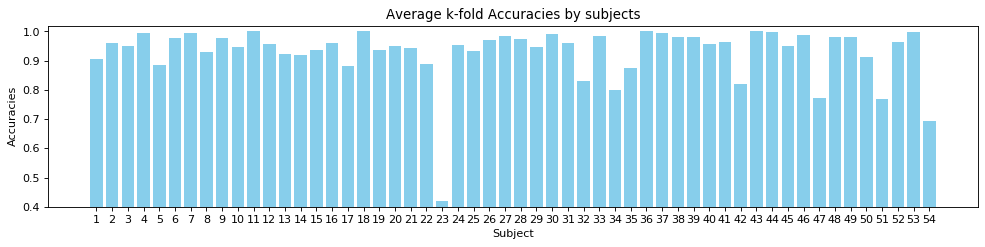

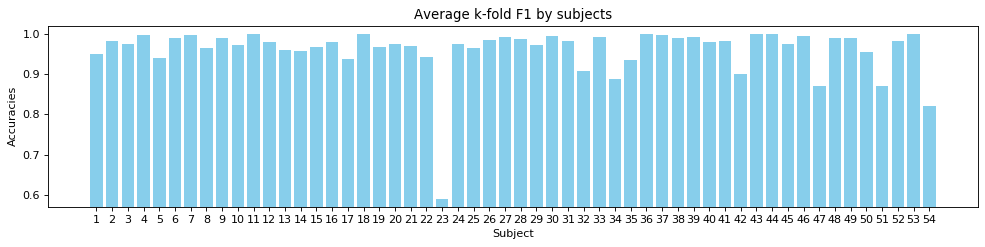

In [13]:
# acc
subjects = []
acc = []
acc_min = 1.0
acc_max = 0.0

for subject_id in subject_kfold_acc:
    subjects.append(subject_id)
    avg_acc = np.mean(subject_kfold_acc[subject_id])
    if avg_acc < acc_min:
        acc_min = avg_acc
    if avg_acc > acc_max:
        acc_max = avg_acc
    acc.append(avg_acc)


x_pos = [i for i, _ in enumerate(subjects)]
figure(num=None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x_pos, acc, color='skyblue')
plt.xlabel("Subject")
plt.ylabel("Accuracies")
plt.title("Average k-fold Accuracies by subjects")
plt.xticks(x_pos, subjects)
plt.ylim([acc_min-0.02, acc_max+0.02])
plt.show()

# f1
subjects = []
f1 = []
f1_min = 1.0
f1_max = 0.0

for subject_id in subject_kfold_f1:
    subjects.append(subject_id)
    avg_f1 = np.mean(subject_kfold_f1[subject_id])
    if avg_f1 < f1_min:
        f1_min = avg_f1
    if avg_f1 > f1_max:
        f1_max = avg_f1
    f1.append(avg_f1)


x_pos = [i for i, _ in enumerate(subjects)]
figure(num=None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x_pos, f1, color='skyblue')
plt.xlabel("Subject")
plt.ylabel("Accuracies")
plt.title("Average k-fold F1 by subjects")
plt.xticks(x_pos, subjects)
plt.ylim([f1_min-0.02, f1_max+0.02])
plt.show()

In [8]:
print('Average acc:', np.mean(acc))
print('Average f1:', np.mean(f1))

Average acc: 0.9287592592592593
Average f1: 0.9598666666666666
